※본 커널은 캐글을 통해 공유된 "M5 Forecasting - Accuracy"(https://www.kaggle.com/c/m5-forecasting-accuracy/data) Competition 의 Notebooks 중 "M5 Forecasting - Starter Data Exploration"(https://www.kaggle.com/robikscube/m5-forecasting-starter-data-exploration) 의 내용을 기반으로 작성되었습니다.

## Colab 사용 환경

In [0]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
cd /content/gdrive/My Drive/JK/M5/src

/content/gdrive/My Drive/JK/M5/src


In [0]:
pwd

'/content/gdrive/My Drive/JK/M5/src'

# M5 Forecasting Challenge
<img src="https://images.ctfassets.net/osv85d77hkdf/7LsZ5bZzvGaG6iwYkoKEUc/84afe0bf84371542fe56e6d5f0b3377b/hero_telescope_01_2x.png" width="500" height="300" />

이 notebook의 목표는 경쟁 참가자에게 2020 M5 경쟁에 대한 간략한 개요를 제공하는 것입니다. 읽은 후에는 해결하려는 목표, 제공된 데이터 및 점수를 매기는 지표(metrics)를 잘 알게 됩니다.

유의할 항목:
- **정확도**와 **불확실성**의 두 가지 병렬 경쟁이 있습니다.
    - 정확도 경쟁에서는 **가중 제곱 평균 오차 Weighted Root Mean Squared Scaled Error**(RMSSE) metric을 사용합니다.
    - 불확실성 경쟁에서는 **Weighted Scaled Pinball Loss**(WSPL) metric을 사용합니다.
- Wal-Mart의 계층적 판매 데이터 예측을 합니다.
- 이 데이터는 미국 3개 주 (캘리포니아, 텍사스, 위스콘신)의 매장을 포함하며 품목 레벨, 부서, 제품 카테고리 및 상점 세부 사항을 포함합니다.
- 또한 가격, 판촉, 요일 및 특별 이벤트와 같은 설명 변수가 있습니다.

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from itertools import cycle
pd.set_option('max_columns', 50)
plt.style.use('bmh')
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data Files
- `calendar.csv` - 제품 판매 날짜에 대한 정보가 들어 있습니다.
- `sales_train_validation.csv` - 제품 및 상점별 과거 일일 단위 판매 데이터를 포함합니다. [d_1 - d_1913]
- `sample_submission.csv` - submissions을 위한 올바른 형식입니다. 자세한 내용은 Evaluation 탭을 참조하십시오.
- `sell_prices.csv` - 상점 및 날짜별로 판매된 제품 가격에 대한 정보를 포함합니다.

제공 예정(Not available yet):
- `sales_train_evaluation.csv` - 대회 마감일 한 달 전에 사용 가능합니다. 판매(sales) 포함 예정 [d_1 - d_1941]

In [0]:
!ls -GFlash --color ../input/m5-forecasting-accuracy/

total 314M
102K -rw------- 1 root 102K Apr 10 12:20 calendar.csv
115M -rw------- 1 root 115M Apr 10 12:20 sales_train_validation.csv
5.0M -rw------- 1 root 5.0M Apr 10 12:20 sample_submission.csv
194M -rw------- 1 root 194M Apr 10 12:20 sell_prices.csv


In [0]:
# Read in the data
INPUT_DIR = '../input/m5-forecasting-accuracy'
cal = pd.read_csv(f'{INPUT_DIR}/calendar.csv')
stv = pd.read_csv(f'{INPUT_DIR}/sales_train_validation.csv')
ss = pd.read_csv(f'{INPUT_DIR}/sample_submission.csv')
sellp = pd.read_csv(f'{INPUT_DIR}/sell_prices.csv')

# 정확히 무엇을 예측하려고 합니까?
28일 동안 예측 판매를 시도하고 있습니다. 샘플 제출의 형식은 다음과 같습니다.:
- 열(columns)은 28 일의 예측일을 나타냅니다. 이 예측일을 예측값으로 채웁니다.
- 각 행(rows)은 특정 항목을 나타냅니다. 이 ID는 항목 유형(item type), 상태(state) 및 상점(store)을 알려줍니다. 이 품목들이 정확히 무엇인지는 알 수 없습니다.

In [0]:
ss.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,HOBBIES_1_005_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


'sales_train_validation' 데이터 세트에 과거 판매 데이터가 제공됩니다.
- d_1 일부터 d_1913 일 동안이 데이터 세트에 행(rows)이 존재합니다. 품목의 부서, 카테고리, 주 및 상점 ID가 제공됩니다.
- d_1914 - d_1941은 1 단계에서 예측할 'validation'  행(rows)을 나타냅니다.
- d_1942 - d_1969는 최종 경쟁 순위에 대해 예측할 'evaluation' 행(rows)을 나타냅니다.

In [0]:
stv.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,...,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,4,2,3,0,1,2,0,0,0,1,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0,0,0,0,1,2,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,3,1,2,1,3,1,0,2,5,4,2,0,3,0,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,4,0,1,4,0,1,0,1,0,1,1,2,0,1,1,2,1,1,0,1,1,2,2,2,4


# 단일 항목의 데이터 시각화
- 많이 판매하는 임의의 항목을 가져와서 판매가 training 데이터에서 어떻게 보이는지 확인할 수 있습니다.
- `FOODS_3_090_CA_3_validation` sells a lot
- 상품을 사용할 수 없고 sales flatline으로 표시되는 날이 있습니다.

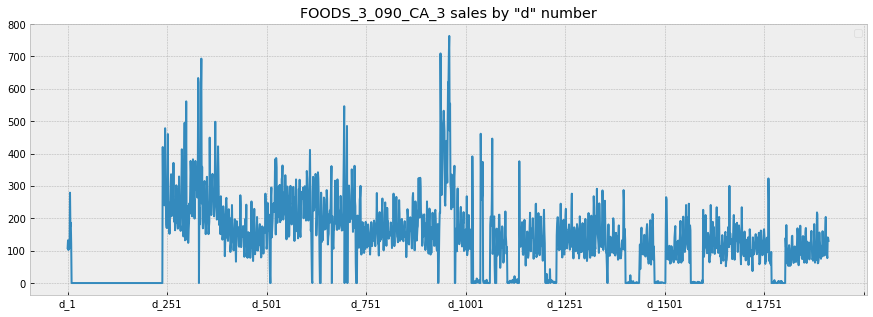

In [0]:
d_cols = [c for c in stv.columns if 'd_' in c] # sales data columns

# Below we are chaining the following steps in pandas:
# 1. Select the item.
# 2. Set the id as the index, Keep only sales data columns
# 3. Transform so it's a column
# 4. Plot the data
stv.loc[stv['id'] == 'FOODS_3_090_CA_3_validation'] \
    .set_index('id')[d_cols] \
    .T \
    .plot(figsize=(15, 5),
          title='FOODS_3_090_CA_3 sales by "d" number',
          color=next(color_cycle))
plt.legend('')
plt.show()

# 실제 날짜와 데이터 병합
- 과거와 미래의 날짜에 대한 추가 정보가 담긴 달력이 제공됩니다.
- 달력 데이터를 요일 데이터와 병합할 수 있습니다.
- 이를 통해 주간 및 연간 추세를 찾을 수 있습니다.

In [0]:
# Calendar data looks like this (only showing columns we care about for now)
cal[['d','date','event_name_1','event_name_2',
     'event_type_1','event_type_2', 'snap_CA']].head()

,d,date,event_name_1,event_name_2,event_type_1,event_type_2,snap_CA
0,d_1,2011-01-29,NaN,NaN,NaN,NaN,0
1,d_2,2011-01-30,NaN,NaN,NaN,NaN,0
2,d_3,2011-01-31,NaN,NaN,NaN,NaN,0
3,d_4,2011-02-01,NaN,NaN,NaN,NaN,1
4,d_5,2011-02-02,NaN,NaN,NaN,NaN,1


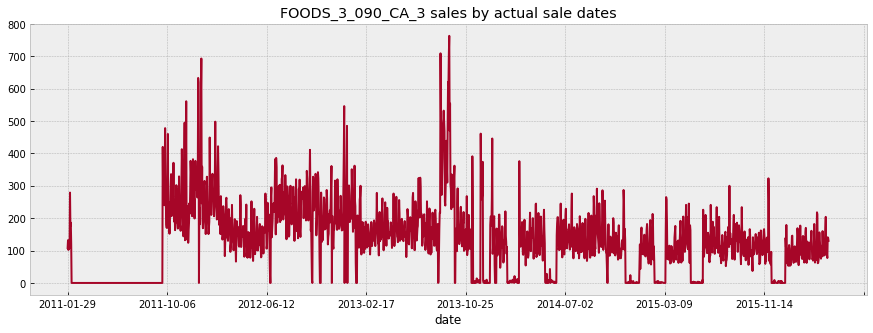

In [0]:
# Merge calendar on our items' data
example = stv.loc[stv['id'] == 'FOODS_3_090_CA_3_validation'][d_cols].T
example = example.rename(columns={8412:'FOODS_3_090_CA_3'}) # Name it correctly
example = example.reset_index().rename(columns={'index': 'd'}) # make the index "d"
example = example.merge(cal, how='left', validate='1:1')
example.set_index('date')['FOODS_3_090_CA_3'] \
    .plot(figsize=(15, 5),
          color=next(color_cycle),
          title='FOODS_3_090_CA_3 sales by actual sale dates')
plt.show()

# Select more top selling examples
example2 = stv.loc[stv['id'] == 'HOBBIES_1_234_CA_3_validation'][d_cols].T
example2 = example2.rename(columns={6324:'HOBBIES_1_234_CA_3'}) # Name it correctly
example2 = example2.reset_index().rename(columns={'index': 'd'}) # make the index "d"
example2 = example2.merge(cal, how='left', validate='1:1')

example3 = stv.loc[stv['id'] == 'HOUSEHOLD_1_118_CA_3_validation'][d_cols].T
example3 = example3.rename(columns={6776:'HOUSEHOLD_1_118_CA_3'}) # Name it correctly
example3 = example3.reset_index().rename(columns={'index': 'd'}) # make the index "d"
example3 = example3.merge(cal, how='left', validate='1:1')

# 시간 변수별로 분류된 판매
- 이제 예제 항목이 있으므로 다음을 기준으로 판매 방법을 확인할 수 있습니다.:
    - Day of the week
    - Month
    - Year

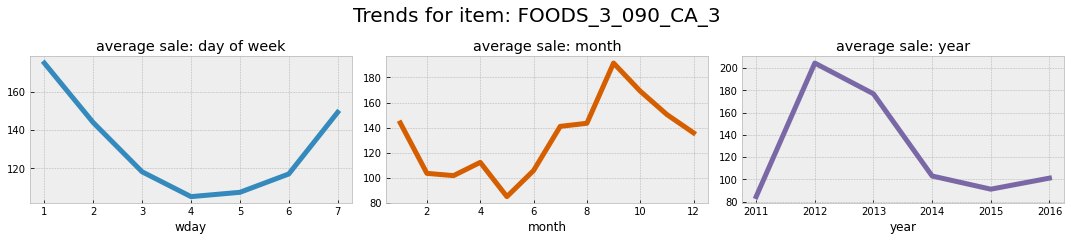

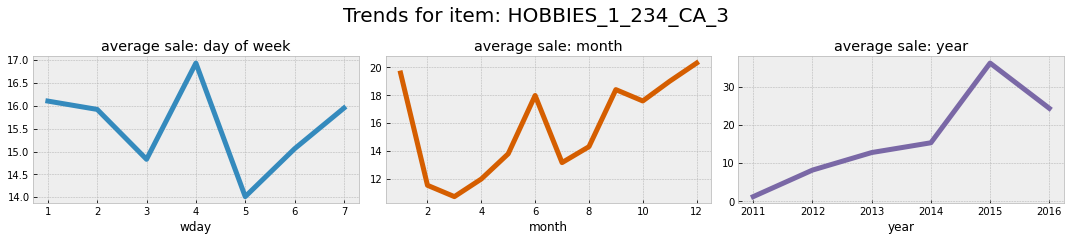

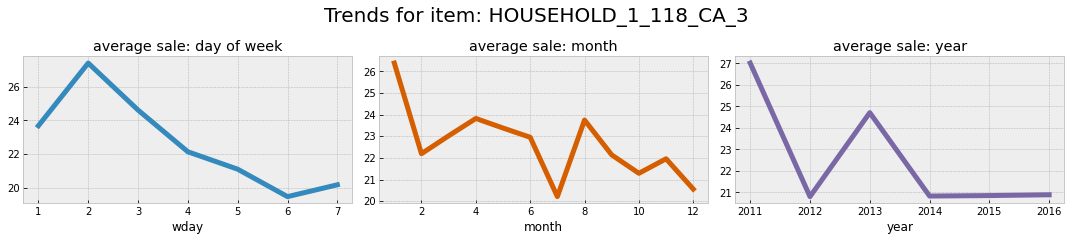

In [0]:
examples = ['FOODS_3_090_CA_3','HOBBIES_1_234_CA_3','HOUSEHOLD_1_118_CA_3']
example_df = [example, example2, example3]
for i in [0, 1, 2]:
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 3))
    example_df[i].groupby('wday').mean()[examples[i]] \
        .plot(kind='line',
              title='average sale: day of week',
              lw=5,
              color=color_pal[0],
              ax=ax1)
    example_df[i].groupby('month').mean()[examples[i]] \
        .plot(kind='line',
              title='average sale: month',
              lw=5,
              color=color_pal[4],

              ax=ax2)
    example_df[i].groupby('year').mean()[examples[i]] \
        .plot(kind='line',
              lw=5,
              title='average sale: year',
              color=color_pal[2],

              ax=ax3)
    fig.suptitle(f'Trends for item: {examples[i]}',
                 size=20,
                 y=1.1)
    plt.tight_layout()
    plt.show()

# 다양한 아이템을 볼 수 있습니다!
- 20가지 품목과 판매량을 구성하기 위해 모두 합칠 수 있습니다.
- 이 plot에서 몇 가지 관찰 사항:
    - 일정 기간 동안 항목을 사용할 수 없는 것이 일반적입니다.
    - 일부 품목은 하루에 1개 이하만 판매하므로 예측하기가 매우 어렵습니다.
    - 다른 품목들은 수요가 급증하는 것을 보여줍니다 (수퍼볼 일요일?). 아마도 우리에게 제공된 "events"가 이것들에 도움이 될 수 있습니다.

In [0]:
twenty_examples = stv.sample(20, random_state=529) \
        .set_index('id')[d_cols] \
    .T \
    .merge(cal.set_index('d')['date'],
           left_index=True,
           right_index=True,
            validate='1:1') \
    .set_index('date')

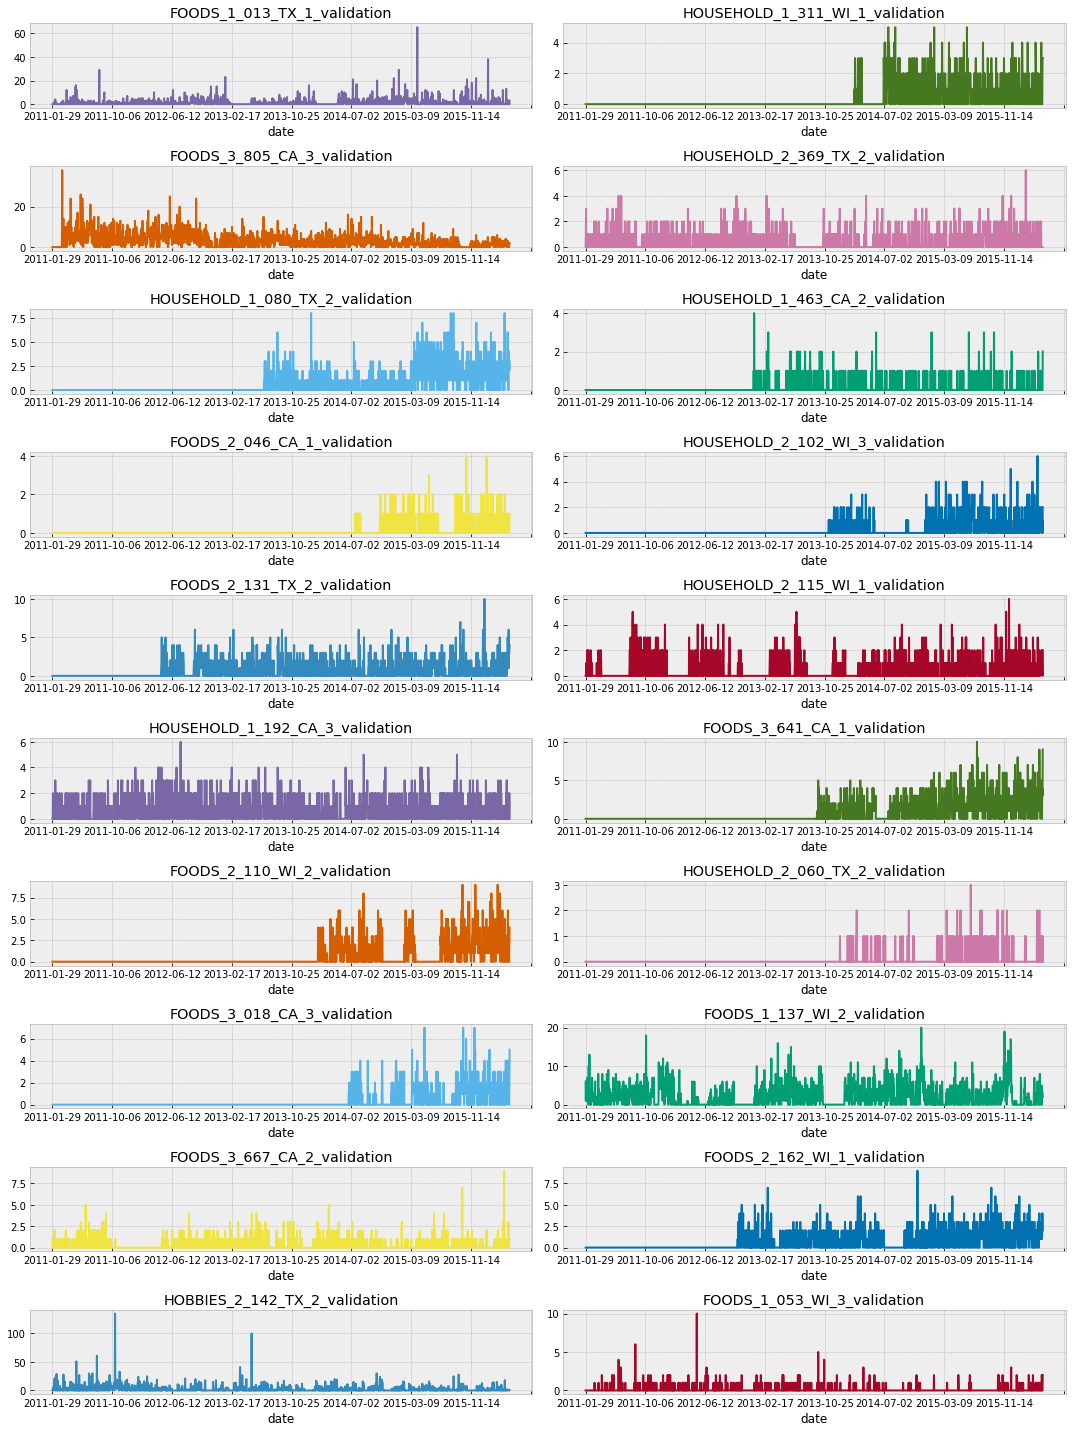

In [0]:
fig, axs = plt.subplots(10, 2, figsize=(15, 20))
axs = axs.flatten()
ax_idx = 0
for item in twenty_examples.columns:
    twenty_examples[item].plot(title=item,
                              color=next(color_cycle),
                              ax=axs[ax_idx])
    ax_idx += 1
plt.tight_layout()
plt.show()

# 유형별 시간별 결합 판매
- 여러 항목 유형이 있습니다.:
    - Hobbies
    - Household
    - Foods
- 각 유형의 시간에 따른 총 수요량을 표시할 수 있습니다.

In [0]:
stv['cat_id'].unique()

array(['HOBBIES', 'HOUSEHOLD', 'FOODS'], dtype=object)

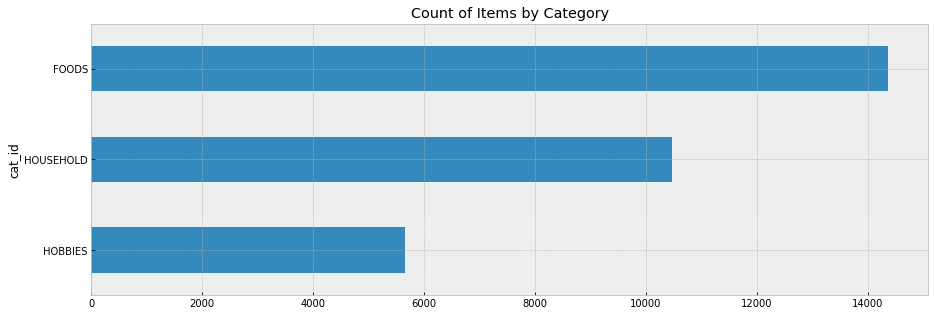

In [0]:
stv.groupby('cat_id').count()['id'] \
    .sort_values() \
    .plot(kind='barh', figsize=(15, 5), title='Count of Items by Category')
plt.show()

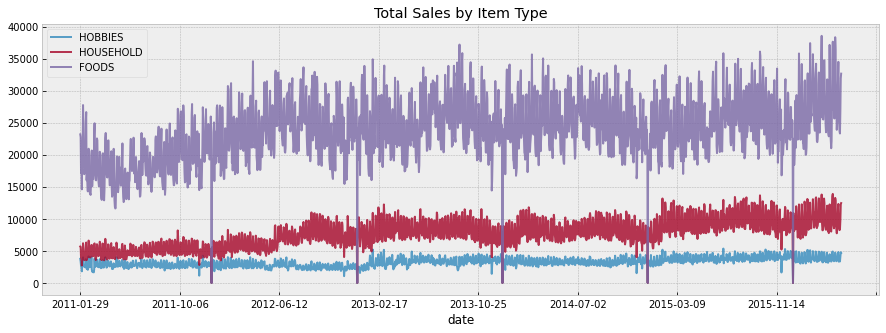

In [0]:
past_sales = stv.set_index('id')[d_cols] \
    .T \
    .merge(cal.set_index('d')['date'],
           left_index=True,
           right_index=True,
            validate='1:1') \
    .set_index('date')


for i in stv['cat_id'].unique():
    items_col = [c for c in past_sales.columns if i in c]
    past_sales[items_col] \
        .sum(axis=1) \
        .plot(figsize=(15, 5),
              alpha=0.8,
              title='Total Sales by Item Type')
plt.legend(stv['cat_id'].unique())
plt.show()

# 판매중인 품목의 롤아웃
- 이전에는 존재하지 않았던 일부 품목이 공급되는 것을 볼 수 있습니다. 마찬가지로 일부 품목은 완전히 판매되지 않습니다.
- 판매량을 표시할 수 있지만 품목이 판매중이거나 판매되지 않은 경우에만 계산합니다 (0-> 판매하지 않음,> 0-> 판매)
- 이 plot은 많은 품목이 재고에 천천히 도입되고 있음을 보여주므로 많은 품목이 제공된 데이터의 시작 부분에 판매를 등록하지 않습니다.

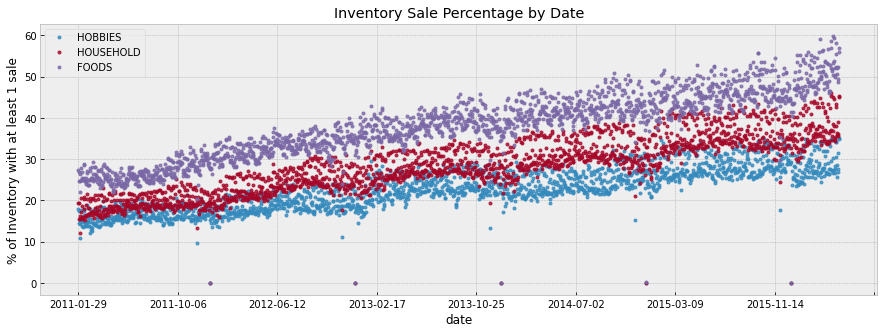

In [0]:
past_sales_clipped = past_sales.clip(0, 1)
for i in stv['cat_id'].unique():
    items_col = [c for c in past_sales.columns if i in c]
    (past_sales_clipped[items_col] \
        .mean(axis=1) * 100) \
        .plot(figsize=(15, 5),
              alpha=0.8,
              title='Inventory Sale Percentage by Date',
              style='.')
plt.ylabel('% of Inventory with at least 1 sale')
plt.legend(stv['cat_id'].unique())
plt.show()

# 매장별 판매
10개의 고유 매장에 대한 데이터가 제공됩니다. 매장별 총 판매량은 얼마입니까?
- 일부 상점은 다른 상점보다 안정적입니다.
- CA_2 는 2015 년에 큰 변화가 있는 것 같습니다.

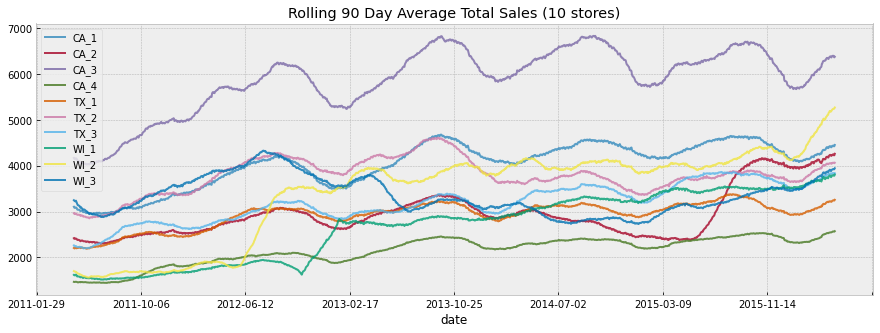

In [0]:
store_list = sellp['store_id'].unique()
for s in store_list:
    store_items = [c for c in past_sales.columns if s in c]
    past_sales[store_items] \
        .sum(axis=1) \
        .rolling(90).mean() \
        .plot(figsize=(15, 5),
              alpha=0.8,
              title='Rolling 90 Day Average Total Sales (10 stores)')
plt.legend(store_list)
plt.show()

동일한 데이터를 다른 방식으로 살펴보면 매장별로 총 7 일 동안의 총 수요 수를 표시할 수 있습니다. 일부 매장은 수요가 급격히 변한다는 점을 명심하십시오. 매장이 확장되거나 근처에 새로운 경쟁사가 생겼을 수 있습니다. 어느 쪽이든 수요 패턴에 대한 예측 모델을 작성할 때 주의해야 합니다.

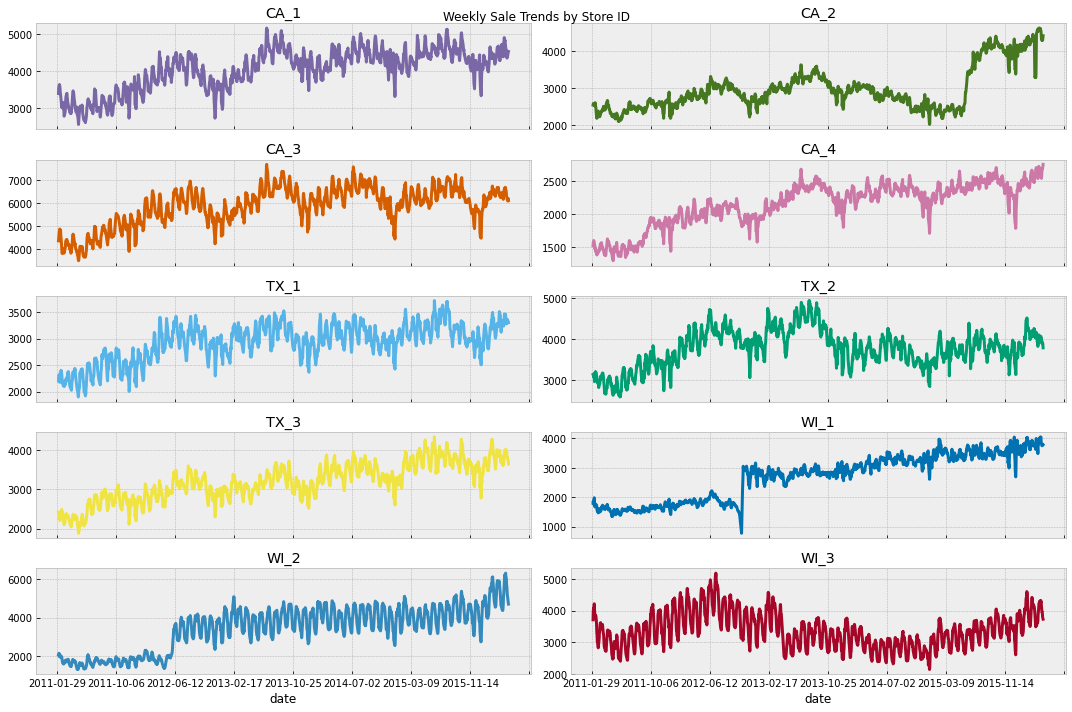

In [0]:
fig, axes = plt.subplots(5, 2, figsize=(15, 10), sharex=True)
axes = axes.flatten()
ax_idx = 0
for s in store_list:
    store_items = [c for c in past_sales.columns if s in c]
    past_sales[store_items] \
        .sum(axis=1) \
        .rolling(7).mean() \
        .plot(alpha=1,
              ax=axes[ax_idx],
              title=s,
              lw=3,
              color=next(color_cycle))
    ax_idx += 1
# plt.legend(store_list)
plt.suptitle('Weekly Sale Trends by Store ID')
plt.tight_layout()
plt.show()

# 판매(Sales) Heatmap Calendar

In [0]:
# ----------------------------------------------------------------------------
# Author:  Nicolas P. Rougier
# License: BSD
# ----------------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from datetime import datetime
from dateutil.relativedelta import relativedelta


def calmap(ax, year, data):
    ax.tick_params('x', length=0, labelsize="medium", which='major')
    ax.tick_params('y', length=0, labelsize="x-small", which='major')

    # Month borders
    xticks, labels = [], []
    start = datetime(year,1,1).weekday()
    for month in range(1,13):
        first = datetime(year, month, 1)
        last = first + relativedelta(months=1, days=-1)

        y0 = first.weekday()
        y1 = last.weekday()
        x0 = (int(first.strftime("%j"))+start-1)//7
        x1 = (int(last.strftime("%j"))+start-1)//7

        P = [ (x0,   y0), (x0,    7),  (x1,   7),
              (x1,   y1+1), (x1+1,  y1+1), (x1+1, 0),
              (x0+1,  0), (x0+1,  y0) ]
        xticks.append(x0 +(x1-x0+1)/2)
        labels.append(first.strftime("%b"))
        poly = Polygon(P, edgecolor="black", facecolor="None",
                       linewidth=1, zorder=20, clip_on=False)
        ax.add_artist(poly)
    
    ax.set_xticks(xticks)
    ax.set_xticklabels(labels)
    ax.set_yticks(0.5 + np.arange(7))
    ax.set_yticklabels(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
    ax.set_title("{}".format(year), weight="semibold")
    
    # Clearing first and last day from the data
    valid = datetime(year, 1, 1).weekday()
    data[:valid,0] = np.nan
    valid = datetime(year, 12, 31).weekday()
    # data[:,x1+1:] = np.nan
    data[valid+1:,x1] = np.nan

    # Showing data
    ax.imshow(data, extent=[0,53,0,7], zorder=10, vmin=-1, vmax=1,
              cmap="RdYlBu_r", origin="lower", alpha=.75)

월마트는 Chirstmas 날에 문을 닫은 것으로 보입니다. 모든 데이터 중 가장 수요가 많은 날은 2016 년 3 월 6 일 일요일이었습니다.이 날에 무슨 일이 있었는지 물어보실 수 있습니다. [CNN이 주최하고 미시간 주 플린트에서 개최된 제 7 차 민주당 대통령 후보 토론은 다음과 같습니다...](https://www.onthisday.com/date/2016/march/6) 

판매량 : D

In [0]:
print('The lowest sale date was:', past_sales.sum(axis=1).sort_values().index[0],
     'with', past_sales.sum(axis=1).sort_values().values[0], 'sales')
print('The lowest sale date was:', past_sales.sum(axis=1).sort_values(ascending=False).index[0],
     'with', past_sales.sum(axis=1).sort_values(ascending=False).values[0], 'sales')

The lowest sale date was: 2012-12-25 with 11 sales
The lowest sale date was: 2016-03-06 with 57218 sales


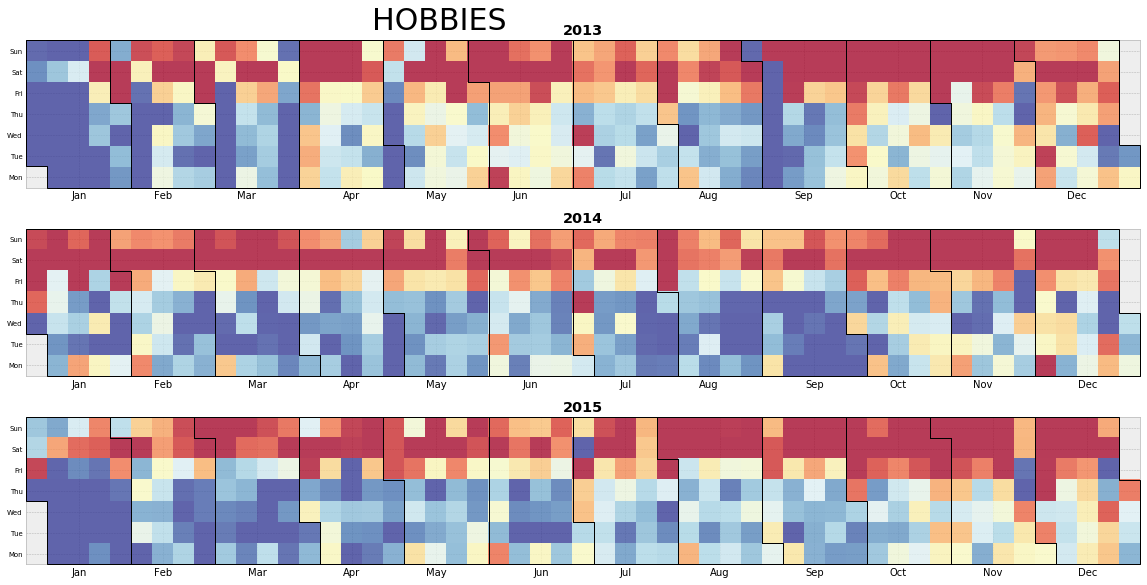

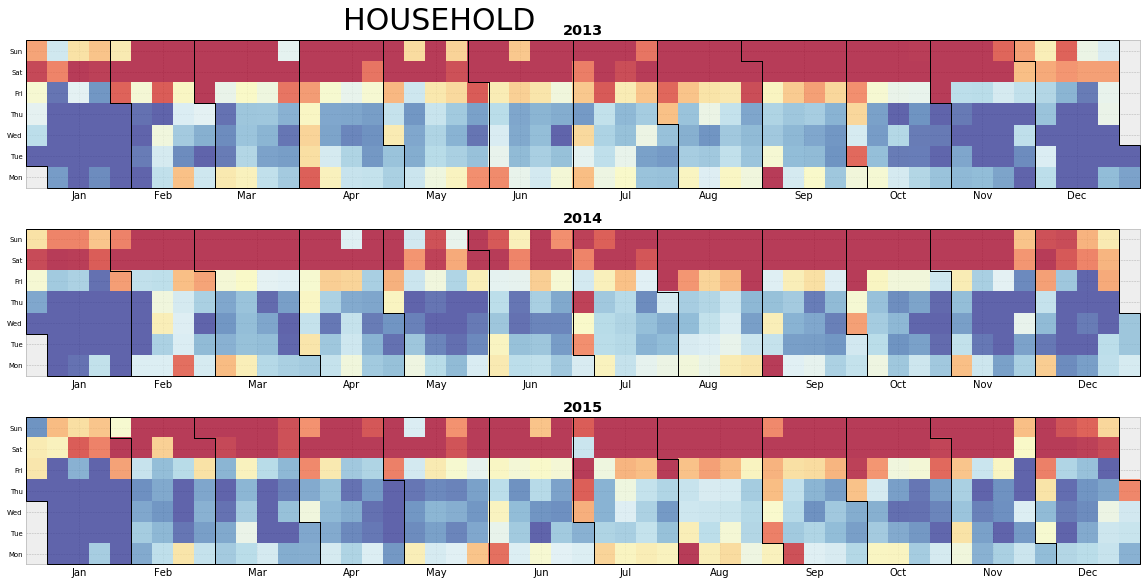

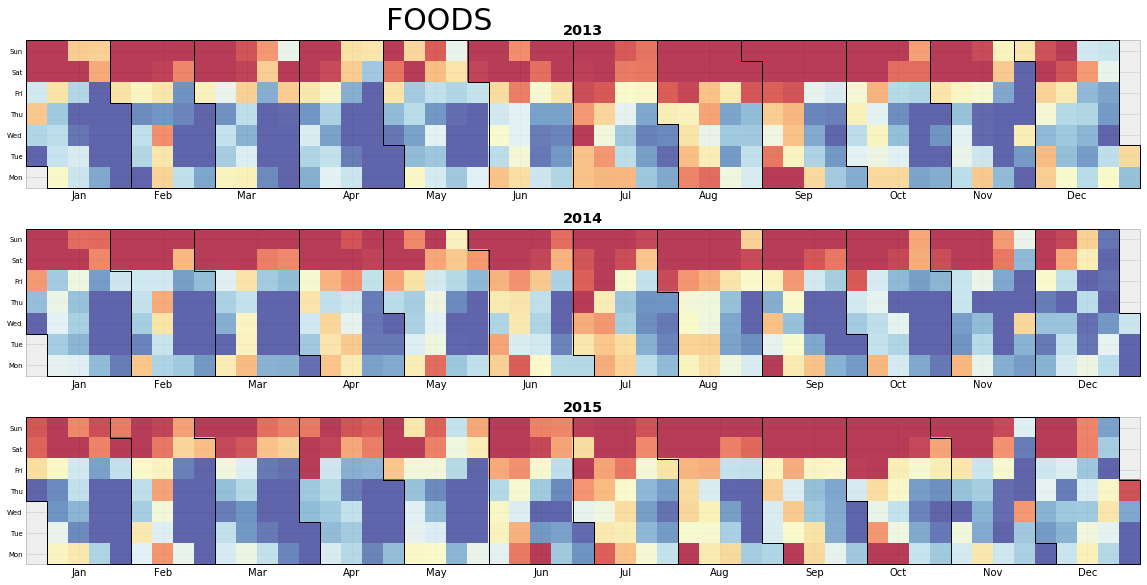

In [0]:
from sklearn.preprocessing import StandardScaler
sscale = StandardScaler()
past_sales.index = pd.to_datetime(past_sales.index)
for i in stv['cat_id'].unique():
    fig, axes = plt.subplots(3, 1, figsize=(20, 8))
    items_col = [c for c in past_sales.columns if i in c]
    sales2013 = past_sales.loc[past_sales.index.isin(pd.date_range('31-Dec-2012',
                                                                   periods=371))][items_col].mean(axis=1)
    vals = np.hstack(sscale.fit_transform(sales2013.values.reshape(-1, 1)))
    calmap(axes[0], 2013, vals.reshape(53,7).T)
    sales2014 = past_sales.loc[past_sales.index.isin(pd.date_range('30-Dec-2013',
                                                                   periods=371))][items_col].mean(axis=1)
    vals = np.hstack(sscale.fit_transform(sales2014.values.reshape(-1, 1)))
    calmap(axes[1], 2014, vals.reshape(53,7).T)
    sales2015 = past_sales.loc[past_sales.index.isin(pd.date_range('29-Dec-2014',
                                                                   periods=371))][items_col].mean(axis=1)
    vals = np.hstack(sscale.fit_transform(sales2015.values.reshape(-1, 1)))
    calmap(axes[2], 2015, vals.reshape(53,7).T)
    plt.suptitle(i, fontsize=30, x=0.4, y=1.01)
    plt.tight_layout()
    plt.show()

이 히트맵에서 주목할 만한 몇 가지 흥미로운 사항:
- 한 달이 지날수록 음식의 구매 횟수는 줄어 듭니다. 사람들이 월초에 월급을 받기 때문일 수 있습니까?
- 휴일 시즌이 끝난 후 1 월에 가정 및 취미 품목의 판매량이 훨씬 적습니다.
- 주말에는 품목 범주에 관계없이 평소보다 더 인기있는 쇼핑 일이 있습니다.

# Sale Prices
우리는 각 품목의 역사적인 판매 가격이 주어집니다. 이전의 예제 항목을 살펴 보겠습니다.
- 이 상품의 가격이 오르고 있는 것 같습니다.
- 상점마다 판매 가격이 다릅니다.

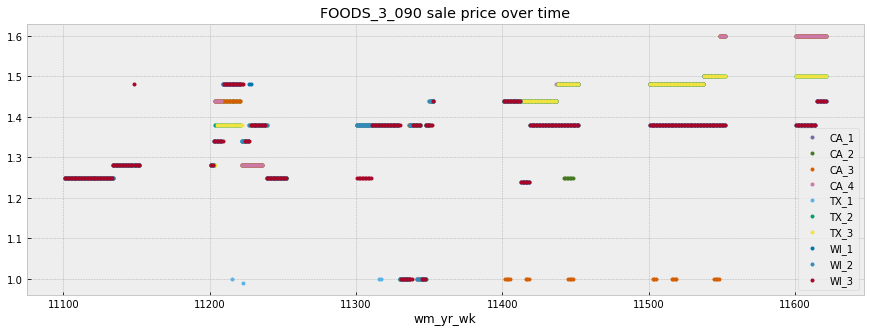

In [0]:
fig, ax = plt.subplots(figsize=(15, 5))
stores = []
for store, d in sellp.query('item_id == "FOODS_3_090"').groupby('store_id'):
    d.plot(x='wm_yr_wk',
          y='sell_price',
          style='.',
          color=next(color_cycle),
          figsize=(15, 5),
          title='FOODS_3_090 sale price over time',
         ax=ax,
          legend=store)
    stores.append(store)
    plt.legend()
plt.legend(stores)
plt.show()

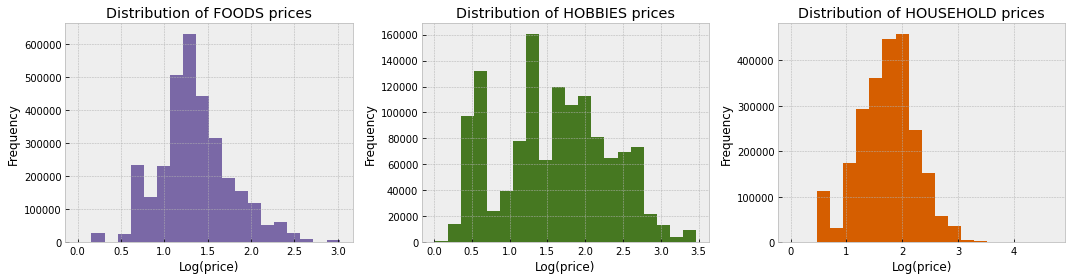

In [0]:
sellp['Category'] = sellp['item_id'].str.split('_', expand=True)[0]
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
i = 0
for cat, d in sellp.groupby('Category'):
    ax = d['sell_price'].apply(np.log1p) \
        .plot(kind='hist',
                         bins=20,
                         title=f'Distribution of {cat} prices',
                         ax=axs[i],
                                         color=next(color_cycle))
    ax.set_xlabel('Log(price)')
    i += 1
plt.tight_layout()

# simple submission
- 지난 30 일 동안의 평균값 제출

In [0]:
thirty_day_avg_map = stv.set_index('id')[d_cols[-30:]].mean(axis=1).to_dict()
fcols = [f for f in ss.columns if 'F' in f]
for f in fcols:
    ss[f] = ss['id'].map(thirty_day_avg_map).fillna(0)
    
ss.to_csv('submission.csv', index=False)

# TODO
- 요일별 과거 평균 판매를 기반으로 한 간단한 예측
- 페이스북 prophet 모델
- 일별 기능을 기반으로 한 lgbm / xgb 모델